# final version

In [63]:
import pandas as pd
import inflection

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# === 1. Load và xử lý cơ bản ===
df = pd.read_csv('../WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.drop('customerID', axis=1, inplace=True)
df.columns = [inflection.underscore(col).replace(' ', '_') for col in df.columns]
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce').fillna(0).astype(float)
df.replace({'No phone service': 'No', 'No internet service': 'No'}, inplace=True)
df['senior_citizen'] = df['senior_citizen'].replace({0: 'No', 1: 'Yes'})

# === 2. Tách cột ===
column_numerical = ['tenure', 'monthly_charges', 'total_charges']
column_categorical = [col for col in df.columns if col not in column_numerical + ['churn']]

# === 3. Split ===
X = df.drop('churn', axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# === 4. Encode y ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# === 5. One-hot encode categorical ===
ohe = OneHotEncoder(sparse_output=False, drop='if_binary')
X_train_cat = ohe.fit_transform(X_train[column_categorical])
X_test_cat = ohe.transform(X_test[column_categorical])

column_ohe = [inflection.underscore(col).replace(' ', '_').replace('_(automatic)', '') for col in ohe.get_feature_names_out()]

X_train_ohe = pd.DataFrame(X_train_cat, columns=column_ohe, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_cat, columns=column_ohe, index=X_test.index)

# === 6. Combine numerical + encoded categorical ===
X_train_enc = pd.concat([X_train[column_numerical], X_train_ohe], axis=1)
X_test_enc = pd.concat([X_test[column_numerical], X_test_ohe], axis=1)

# === 7. Scale numerical ===
scaler = MinMaxScaler()
X_train_enc[column_numerical] = scaler.fit_transform(X_train_enc[column_numerical])
X_test_enc[column_numerical] = scaler.transform(X_test_enc[column_numerical])

# === 8. SMOTE ===
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_enc, y_train_enc)

# === 9. Feature selection ===
selector = RFE(LogisticRegression(random_state=1), n_features_to_select=13)
selector.fit(X_train_smote, y_train_smote)

X_train_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test_enc)

# === 10. Train model ===
best_model = LGBMClassifier(random_state=1, num_leaves=10, n_estimators=175, learning_rate=0.01)
best_model.fit(X_train_selected, y_train_smote)


[LightGBM] [Info] Number of positive: 3622, number of negative: 3622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 7244, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.01, n_estimators=175, num_leaves=10,
               random_state=1)

## evaluation

### get_score func()

In [54]:
def get_score(y_pred, y_test, average=None, plot=True, axis=0, cmap='Blues'):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average) if average else precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average=average) if average else recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=average) if average else f1_score(y_test, y_pred)
    try:
        roc_auc = roc_auc_score(y_test, y_pred)
    except:
        roc_auc = None

    score_df = pd.DataFrame([{
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }])

    if plot:
        display(score_df.style.background_gradient(axis=axis, cmap=cmap))
        
    result_df = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred
    })
    result_df['correct'] = result_df['actual'] == result_df['predicted']

    if plot:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    return score_df, result_df

### evaluate

,accuracy,precision,recall,f1_score,roc_auc
0,0.756744,0.528554,0.775401,0.628613,0.762701


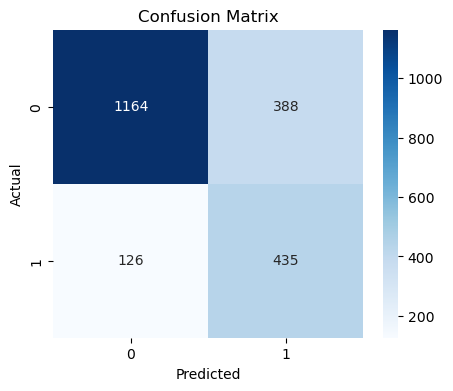

In [64]:
y_pred = best_model.predict(X_test_selected)

score_fs_tuned, result_comparison = get_score(y_pred, y_test_enc)

In [62]:
X_test_enc

,tenure,monthly_charges,total_charges,gender_male,senior_citizen_yes,partner_yes,dependents_yes,phone_service_yes,multiple_lines_yes,internet_service_dsl,...,streaming_tv_yes,streaming_movies_yes,contract_month_to_month,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_bank_transfer,payment_method_credit_card,payment_method_electronic_check,payment_method_mailed_check
1630,0.527778,0.839063,0.461634,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2008,0.055556,0.684604,0.039316,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2685,1.000000,0.819631,0.844470,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
903,0.777778,0.868959,0.698767,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3905,0.041667,0.167414,0.012545,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5352,0.361111,0.799701,0.292120,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2283,0.013889,0.529646,0.008239,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1045,0.597222,0.806178,0.484749,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2115,0.986111,0.999003,0.976142,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [58]:
df['original_index'] = df.index  # Lưu chỉ số gốc vào cột mới 'original_index'

In [65]:
# Lọc các bản ghi dự đoán sai
incorrect_predictions = result_comparison[result_comparison['correct'] == True]

# Lấy index gốc
incorrect_indices = incorrect_predictions.index.tolist()

# Truy ngược lại dữ liệu gốc
incorrect_data_in_df = df.loc[incorrect_indices]

# Hiển thị các bản ghi đoán sai
display(incorrect_data_in_df)


,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,No,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Male,No,Yes,Yes,55,Yes,No,DSL,Yes,No,No,No,No,Yes,One year,No,Credit card (automatic),59.45,3157.00,No
2107,Male,No,Yes,No,33,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,93.35,3092.00,No
2109,Male,No,No,No,34,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Bank transfer (automatic),26.10,980.35,No
2111,Male,No,Yes,Yes,30,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,21.25,711.90,No


,tenure,monthly_charges,total_charges,dependents_yes,phone_service_yes,internet_service_fiber_optic,online_security_yes,online_backup_yes,tech_support_yes,contract_month_to_month,contract_two_year,paperless_billing_yes,payment_method_electronic_check,true_label,predicted_label,correct
0,0.527778,0.839063,0.461634,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0,1,False
1,0.055556,0.684604,0.039316,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1,1,True
2,1.000000,0.819631,0.844470,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,True
3,0.777778,0.868959,0.698767,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,True
4,0.041667,0.167414,0.012545,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,True


## save model

In [ ]:
from joblib import dump

# Lưu mô hình
dump(best_model, 'lightgbm_churn_model_ver2.pkl')

# === Lấy tên các cột được chọn ===
selected_columns = X_train_enc.columns[selector.get_support()].tolist()
print("Các feature được chọn bởi RFE:")
print(selected_columns)

# Lưu danh sách tên cột đã chọn
dump(selected_columns, 'selected_features.pkl')

result_comparison = pd.DataFrame({
    'true_label': y_test_enc,
    'predicted_label': y_pred,
    'correct': y_pred == y_test_enc
}, index=X_test_enc.index)

# Gắn thêm dữ liệu gốc đã được chọn feature vào để tiện theo dõi
comparison_full = pd.concat([X_test_selected_df, result_comparison], axis=1)

# Hiển thị ví dụ
display(comparison_full.head())

# === Dữ liệu X_test_selected dưới dạng DataFrame ===
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns, index=X_test_enc.index)

dump(X_test_selected_df, 'X_test_selected_df.pkl')
dump(comparison_full, 'comparison_test_result.pkl')
# Optional: Hiển thị để kiểm tra
display(X_test_selected_df.head())


Các feature được chọn bởi RFE:
['tenure', 'monthly_charges', 'total_charges', 'dependents_yes', 'phone_service_yes', 'internet_service_fiber_optic', 'online_security_yes', 'online_backup_yes', 'tech_support_yes', 'contract_month_to_month', 'contract_two_year', 'paperless_billing_yes', 'payment_method_electronic_check']


,tenure,monthly_charges,total_charges,dependents_yes,phone_service_yes,internet_service_fiber_optic,online_security_yes,online_backup_yes,tech_support_yes,contract_month_to_month,contract_two_year,paperless_billing_yes,payment_method_electronic_check
0,0.527778,0.839063,0.461634,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1,0.055556,0.684604,0.039316,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1.000000,0.819631,0.844470,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.777778,0.868959,0.698767,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.041667,0.167414,0.012545,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
